In [1]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy, TripletLoss, CircleLoss
from train import train_epoch_mmd
from utils import plot_train, preproc_filter, load_batches, vis_embedding
from dataset import dataset
from scipy import sparse

import utils
import model
import train
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.preprocessing import LabelEncoder

In [2]:
le = LabelEncoder()

## New version for 8 batches
There seems to be some issue with the original implementation, so I re-write the training and dataset generation code. The clusters are better separated this time. Please check the new code when you have time.

-Ziqi

In [3]:
class dataset(Dataset):

    def __init__(self, counts, anno, time_point):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        self.counts = torch.FloatTensor(counts)

        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        self.anno = torch.Tensor(anno)
        self.libsizes = torch.FloatTensor(self.libsizes)
        self.time_point = torch.Tensor(time_point)

    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"time_point": self.time_point[idx] , "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"time_point": self.time_point[idx] ,"count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample


In [4]:
a = CircleLoss(m=0.25, gamma=0.05)
b = torch.Tensor([[1,2,3], [1,1,3], [2,2,2]])
label = torch.Tensor([1,2, 2])
# print(b,)
a(b, label)

tensor(7.8904)

In [5]:
dir = './data/scp_gex_matrix/sepsis_test_7533/'
# 0, 1, 2, 3, 4, 5, 6,
names = ['Control', 'Leuk-UTI', 'Int-URO', 'URO', 'Bac-SEP', 'ICU-SEP', 'ICU-NoSEP']
batchsize = 32
nbatches = len(names)*2
ngenes = 7533
seed = 0
# obtain the feature name
# genes = pd.read_csv(dir + "gene.csv", header = None).values.squeeze()
# ngenes = genes.shape[0]

torch.manual_seed(seed)
np.random.seed(seed)

sc_datasets = []
train_loaders = []
test_loaders = []
for n in np.arange(1,3):
    for name in names:
        counts_rna = np.array(sparse.load_npz(os.path.join(dir, 'sampled_mtx_{}_batch_{}.npz'.format(name, n))).todense())
        anno = pd.read_csv(os.path.join(dir, 'sampled_meta_{}_batch_{}.csv'.format(name, n)))["Cell_Type"]
        anno = le.fit_transform(anno)

        sc_dataset = dataset(counts = counts_rna, anno = anno, time_point=[names.index(name)] * len(anno))
        sc_datasets.append(sc_dataset)
        train_loaders.append(DataLoader(sc_dataset, batch_size = batchsize, shuffle = True))
        test_loaders.append(DataLoader(sc_dataset, batch_size = len(sc_dataset), shuffle = False))

In [6]:
le.fit_transform(['T', 'Mono', 'NK', 'B', 'DC'])

array([4, 2, 3, 0, 1])

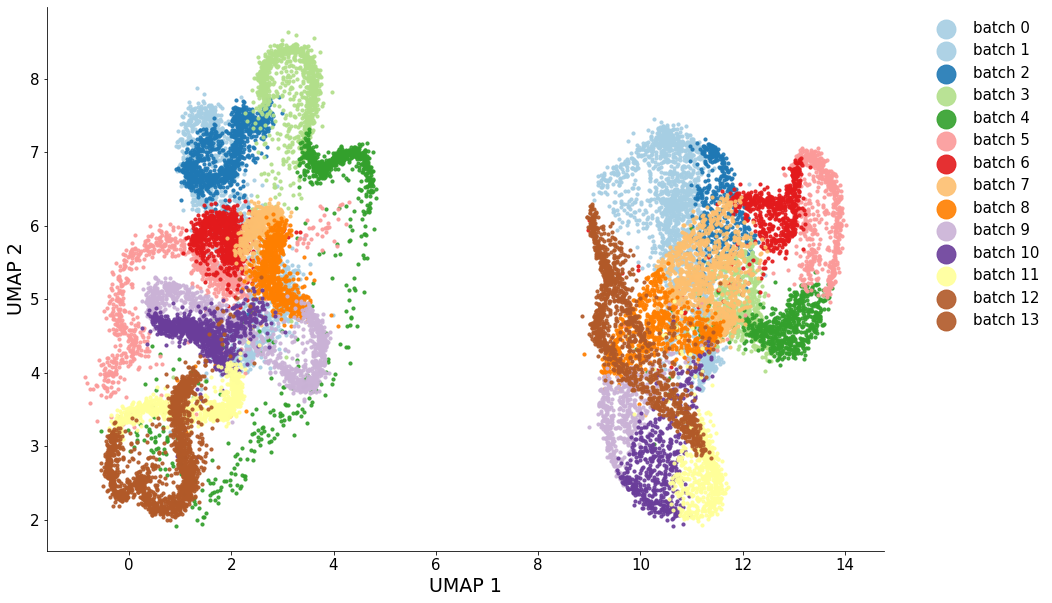

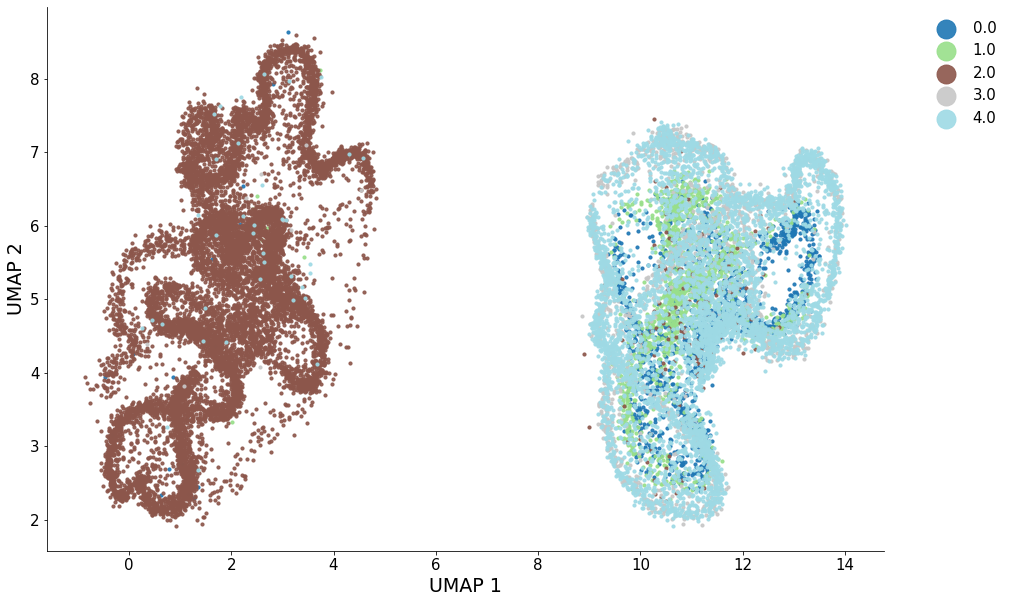

In [7]:
# before integration
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.1, random_state = 0) 
counts_norms = []
annos = []
for batch in range(nbatches):
    counts_norms.append(sc_datasets[batch].counts_norm)
    annos.append(sc_datasets[batch].anno)

x_umap = umap_op.fit_transform(np.concatenate(counts_norms, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

save_file = None

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


In [8]:
import importlib
importlib.reload(train)

<module 'train' from './src/train.py'>

In [25]:
def train_epoch_mmd(model_dict, train_data_loaders, test_data_loaders, optimizer, 
                    n_epoches = 100, interval = 10, lamb_mmd = 1e-3, lamb_pi = 1e-5, 
                    use_zinb = True, contr_factor=1e-1, contr_loss=None, cont=False):
    loss_zinb_tests = []
    loss_mmd_tests = []
    loss_tests = []
    contr_loss_tests = []
    contr_feature = 'time_point'
    for epoch in range(n_epoches + 1):
        # train the model
        for data_batch in zip(*train_data_loaders):
            loss_mmd = 0
            loss_zinb = 0
            loss_contr = 0
            loss_contr_type = 0
            for idx, x in enumerate(data_batch):
                z = model_dict["encoder"](x["count_stand"].to(device))
                mu, pi, theta = model_dict["decoder"](z)
                
                z = model_dict["encoder"](x["count_stand"].to(device))
                mu, pi, theta = model_dict["decoder"](z)
                # negative log likelihood
                if use_zinb:
                    loss_zinb += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(device), y_pred = mu)
                else:
                    # if not use ZINB, then assume the data is Gaussian instead
                    loss_zinb += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()
                    
                # if there are more than 1 batch, calculate mmd loss between current batch and previous batch
                if (len(data_batch) >= 2) & (idx > 0):
                    loss_mmd += maximum_mean_discrepancy(z_pre, z)
                    if contr_loss:
                        loss_contr += contr_loss(torch.cat((z.to(device), z_pre.to(device)), dim=0), torch.cat((x[contr_feature].to(device), label_pre.to(device))))
                        loss_contr_type += contr_loss(torch.cat((z.to(device), z_pre.to(device)), dim=0), torch.cat((x['anno'].to(device), type_pre.to(device))))
                    else:
                        loss_contr += torch.FloatTensor([0]).to(device)
                else:
                    loss_mmd += torch.FloatTensor([0]).to(device)

                z_pre = z.clone()
                label_pre = (x[contr_feature]).clone()
                type_pre = (x['anno']).clone()

            loss = loss_zinb + lamb_mmd * loss_mmd + loss_contr * contr_factor + loss_contr_type * 0.0
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # test the model
        if epoch % interval == 0:
            loss_mmd_test = 0
            loss_zinb_test = 0 
            loss_contr_test = 0
            loss_contr_type_test = 0
            for data_batch in zip(*test_data_loaders):
                with torch.no_grad():
                    for idx, x in enumerate(data_batch):
                        z = model_dict["encoder"](x["count_stand"].to(device))
                        mu, pi, theta = model_dict["decoder"](z)
                        if use_zinb:
                            loss_zinb_test += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x['count'].to(device), y_pred = mu)
                        else:
                            loss_zinb_test += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()

                        if (len(data_batch) >= 2) & (idx > 0):
                            loss_mmd_test += maximum_mean_discrepancy(z_pre, z)

                            if contr_loss:
                                loss_contr_test += contr_loss(torch.cat((z, z_pre), dim=0), torch.cat((x[contr_feature], label_pre)))
                                loss_contr_type_test += contr_loss(torch.cat((z, z_pre), dim=0), torch.cat((x['anno'], type_pre)))
                            else: 
                                loss_contr_test = 0
                        else:
                            loss_mmd_test += torch.FloatTensor([0]).to(device)
                        z_pre = z.clone()
                        label_pre = torch.Tensor(x[contr_feature]).clone()
                        type_pre = torch.Tensor(x['anno']).clone()
                        loss_test = loss_zinb_test + lamb_mmd * loss_mmd_test + loss_contr_test * contr_factor + loss_contr_type_test * 0.0

            info = [
                'mmd loss: {:.3f}'.format(loss_mmd_test.item()),
                'ZINB loss: {:.3f}'.format(loss_zinb_test.item()),
                'overall loss: {:.3f}'.format(loss_test.item()),
                'triplet loss: {:.3f}'.format(loss_contr_test),
            ]

            print("epoch: ", epoch)
            for i in info:
                print("\t", i)
            contr_loss_tests.append(loss_contr_test)
            loss_mmd_tests.append(loss_mmd_test.item())
            loss_zinb_tests.append(loss_zinb_test.item())
            loss_tests.append(loss_test.item())
    return loss_tests, loss_mmd_tests, loss_zinb_tests, contr_loss_tests

In [60]:
# initialize the model
ldim = 32
lr = 5e-4
model_dict = {}
model_dict["encoder"] = model.Encoder(features = [ngenes, 256, 32, ldim], dropout_rate = 0, negative_slope = 0.2).to(device)
model_dict["decoder"] = model.Decoder(features = [ldim, 32, 256, ngenes], dropout_rate = 0, negative_slope = 0.2).to(device)
# initialize the optimizer
param_to_optimize = [
    {'params': model_dict["encoder"].parameters()},
    {'params': model_dict["decoder"].parameters()}
]

optim_ae = torch.optim.Adam(param_to_optimize, lr=lr)
contrastive_loss = CircleLoss(m=0.25, gamma= 1e-3)
# contrastive_loss = TripletLoss(margin=0.3)
contr_factor = 1e-1
n_epoches = 30
losses = train_epoch_mmd(model_dict, train_data_loaders = train_loaders, test_data_loaders = test_loaders, 
                      optimizer = optim_ae, n_epoches = n_epoches, interval = 10, lamb_mmd = 5e-2, 
                      lamb_pi = 1e-5, use_zinb = True, contr_factor=contr_factor,contr_loss=contrastive_loss)



epoch:  0
	 mmd loss: 0.380
	 ZINB loss: 10.208
	 overall loss: 48.276
	 triplet loss: 380.491
epoch:  10
	 mmd loss: 0.162
	 ZINB loss: 6.109
	 overall loss: 44.145
	 triplet loss: 380.286
epoch:  20
	 mmd loss: 0.161
	 ZINB loss: 5.812
	 overall loss: 43.849
	 triplet loss: 380.284
epoch:  30
	 mmd loss: 0.166
	 ZINB loss: 5.733
	 overall loss: 43.769
	 triplet loss: 380.284


True cluster number: 5
NMI Score :  0.6209850124656432 
 ARI Score:  0.6209850124656432


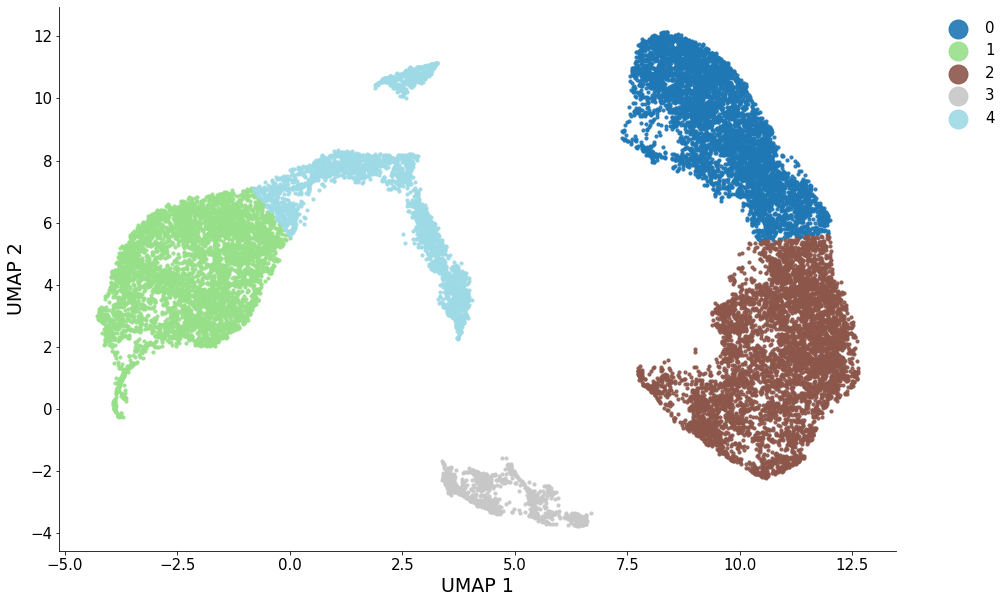

In [61]:
# Using KMeans with NMI and ARI metrics
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARI

zs = []
for data_batch in zip(*test_loaders):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())
            
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

y_true = list(torch.cat(annos))
k = torch.cat(annos).unique().shape[0]
print('True cluster number:', k)
kmeans = KMeans(n_clusters=k, random_state=0).fit(x_umap)
y_pre = kmeans.labels_

nmi_score = NMI(y_true, y_pre)
air_score = NMI(y_true, y_pre)
print('NMI Score : ', nmi_score, '\n', 'ARI Score: ', air_score)
# separate into batches
x_umaps = []
y_pre_annos = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        y_pre_annos.append(y_pre[start_pointer:end_pointer])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
        y_pre_annos.append(y_pre[start_pointer:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        y_pre_annos.append(y_pre[start_pointer:end_pointer])

utils.plot_latent(x_umaps, annos = y_pre_annos, mode = "joint", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

In [62]:
# data = ad.AnnData(np.concatenate(zs))
# # data.obs['label'] = y_pre
# sc.pp.neighbors(data)
# # sc.tl.umap(data)
# # sc.pl.umap(data, color='label')
# sc.tl.leiden(data)
# y_pre = data.obs['leiden']
# for batch in range(nbatches):
#     if batch == 0:
#         start_pointer = 0
#         end_pointer = start_pointer + zs[batch].shape[0]
#         x_umaps.append(x_umap[start_pointer:end_pointer,:])
#         y_pre_annos.append(y_pre[start_pointer:end_pointer])
#     elif batch == (nbatches - 1):
#         start_pointer = start_pointer + zs[batch - 1].shape[0]
#         x_umaps.append(x_umap[start_pointer:,:])
#         y_pre_annos.append(y_pre[start_pointer:])
#     else:
#         start_pointer = start_pointer + zs[batch - 1].shape[0]
#         end_pointer = start_pointer + zs[batch].shape[0]
#         x_umaps.append(x_umap[start_pointer:end_pointer,:])
#         y_pre_annos.append(y_pre[start_pointer:end_pointer])

# utils.plot_latent(x_umaps, annos = y_pre_annos, mode = "joint", save = None, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

## Loss plot
The change of loss function with iterations

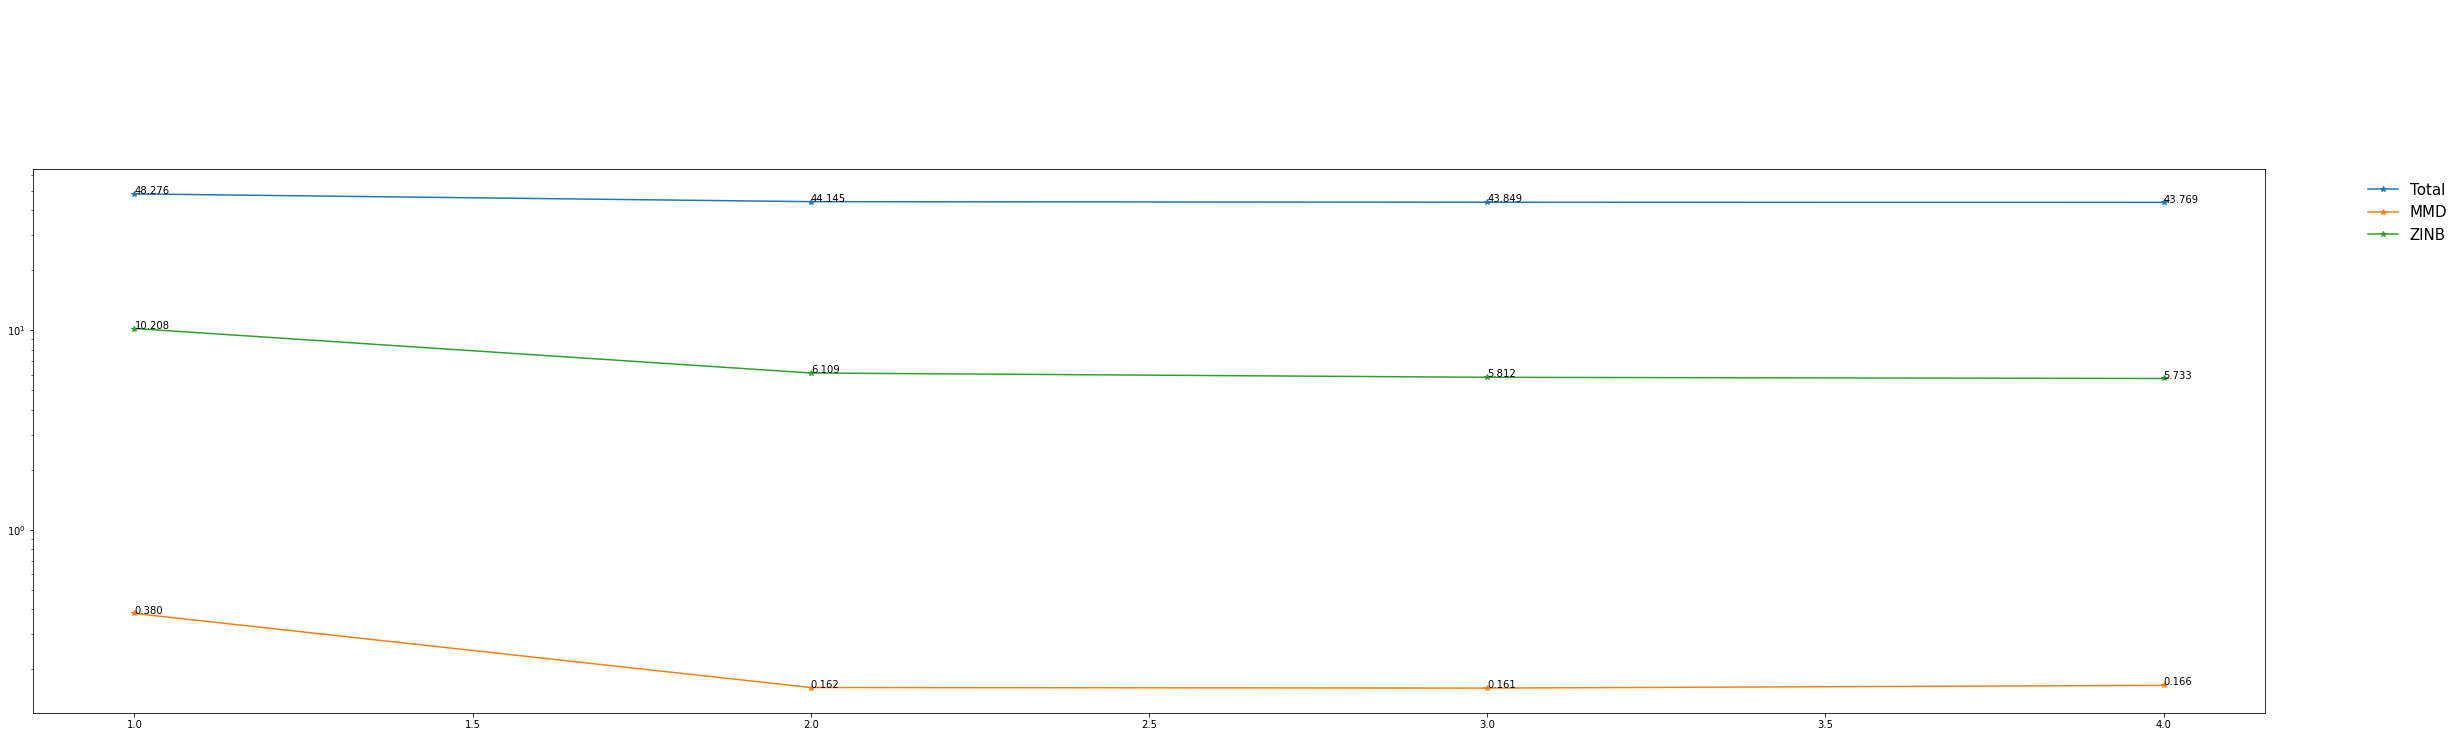

In [63]:

loss_total = losses[0]
loss_mmd = losses[1]
loss_zinb = losses[2]
loss_triplet = losses[3]

iterations = np.arange(1, len(loss_mmd) + 1)
fig = plt.figure(figsize = (40, 10))
ax = fig.add_subplot()
ax.plot(iterations, loss_total, "-*", label = "Total")
ax.plot(iterations, loss_mmd, "-*", label = "MMD")
ax.plot(iterations, loss_zinb, "-*",label = "ZINB")
# ax.plot(iterations, loss_triplet.cpu(), "-*",label = "TRIPLET")
ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
ax.set_yscale("log")
for i,j in zip(iterations,loss_zinb):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_mmd):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_total):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_triplet):
    ax.annotate("{:.3f}".format(j),xy=(i,j)) 

## Visualization of batch 5 and 6
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


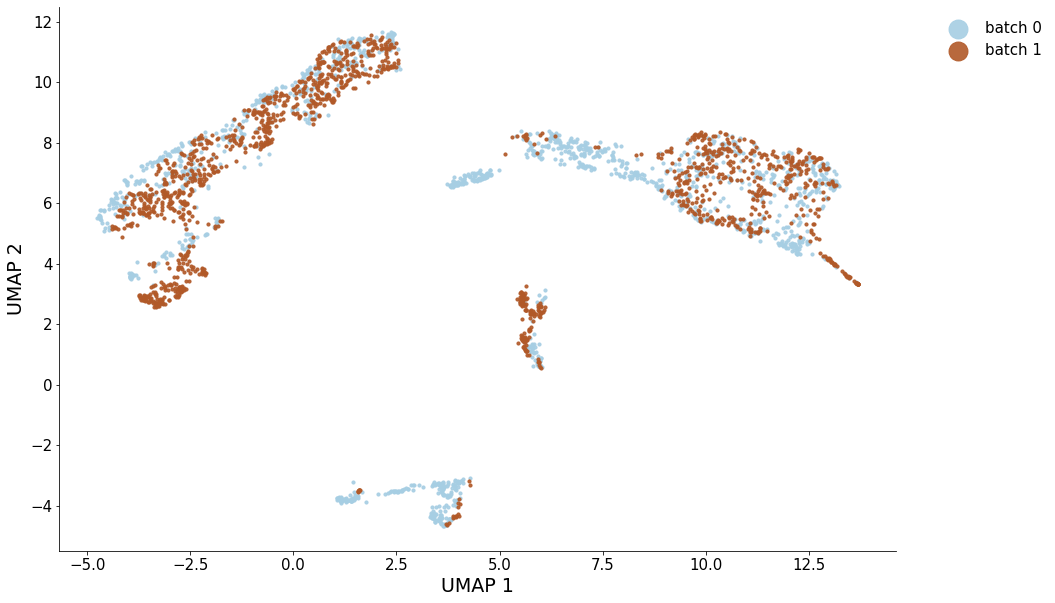

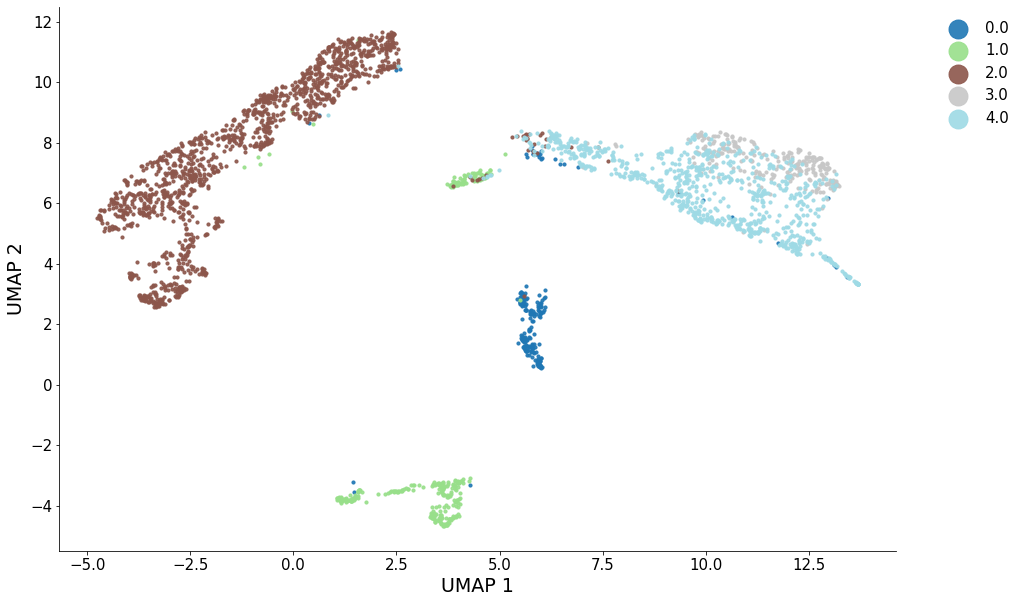

In [66]:
zs = []
import time
# Each time point has to batch id: 1 and 2, so k and k+7 should match since they are from the same time point
# for i in range(6):
#     for j in range(i+1, 7):
batch_id_1, batch_id_2 = 0, 6
test_loaders_sub = [test_loaders[batch_id_1], test_loaders[batch_id_2]]
nbatches_sub = len(test_loaders_sub)
for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())

annos_sub = [annos[batch_id_1], annos[batch_id_2]]

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
comment = 'MMD_0.05_CIRCLE_TYPE&TIME'
path = '/net/csefiles/xzhanglab/xzhao429/Projects/AntennaVAE/sepsis_results/report_7533/mmd_0.5_contr_0.1_all_2_batch/'
save_file_id = path + 'id_sepsis_contr_{}_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, contr_factor,batch_id_1, batch_id_2, n_epoches)
save_file_type = path + 'type_sepsis_contr_{}_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, contr_factor,batch_id_1, batch_id_2,n_epoches )
save_file = None
utils.plot_latent(x_umaps, annos = annos_sub, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of all 8 batches
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


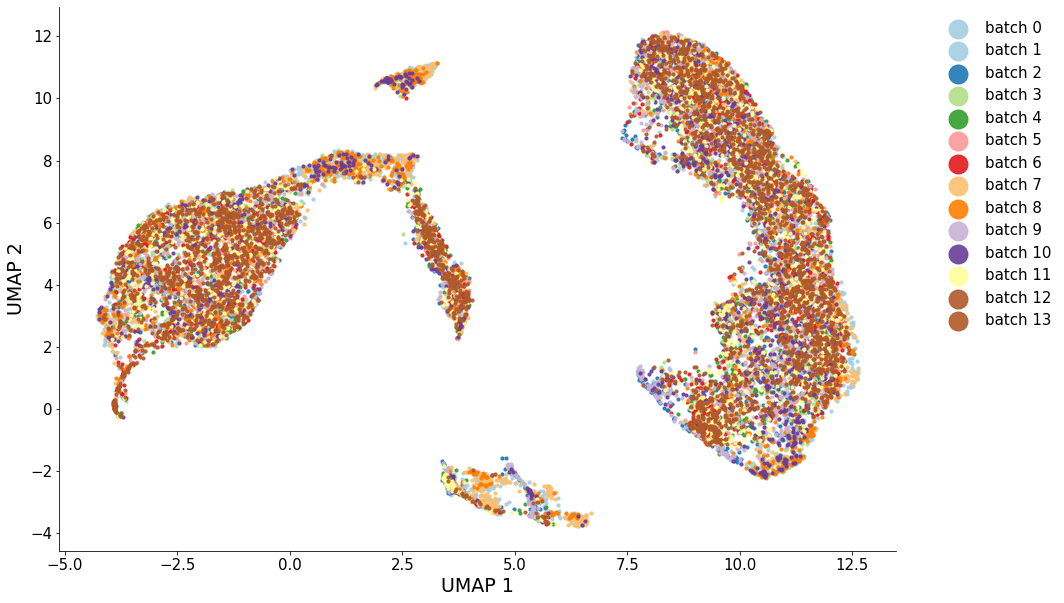

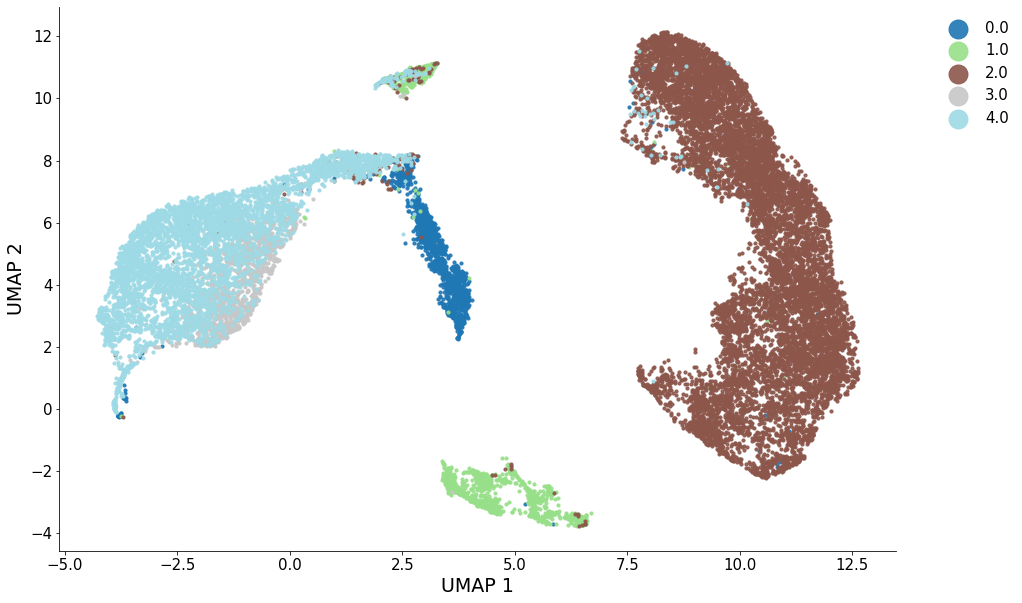

In [65]:
zs = []
for data_batch in zip(*test_loaders):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())
            
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
comment = 'MMD_0.05_CIRCLE_ALL_BATCH'
save_file_id = path + 'id_sepsis_{}_contr_{}_epoch_{}.png'.format(comment, contr_factor, n_epoches)
save_file_type = path + 'type_sepsis_{}_contr_{}_epoch_{}.png'.format(comment, contr_factor,n_epoches)

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")
